# Ride-Sharing Revenue Prediction Project
## Notebook 02: Data Cleaning & Preprocessing

**Objective:** Clean and preprocess the raw dataset to create a high-quality dataset ready for exploratory data analysis and modeling.

**This Notebook Covers:**
1. Loading raw data and exploration insights
2. Handling missing values with documented strategies
3. Parsing and engineering temporal features
4. Data type conversions and validation
5. Outlier detection and treatment
6. Categorical variable processing
7. Final data validation and quality checks
8. Saving cleaned dataset

**Author:** Victor Gomes  
**Date:** January 2025

---
**Key Decisions Made:**
- Missing value strategies documented and justified
- Outlier treatment approach explained
- All transformations reversible and traceable

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

# Configure display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✓ All libraries imported successfully!
Pandas version: 3.0.0
NumPy version: 2.3.5


In [2]:
# Load the raw dataset
data_path = "../data/raw/ncr_ride_bookings.csv"

print("Loading dataset...")
df_raw = pd.read_csv(data_path)

# Create a working copy to preserve raw data
df = df_raw.copy()

print(f"✓ Dataset loaded successfully!")
print(f"Original shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Loading dataset...
✓ Dataset loaded successfully!
Original shape: 150,000 rows × 21 columns
Memory usage: 100.71 MB


In [3]:
# Quick overview
print("=" * 80)
print("INITIAL DATASET STATE")
print("=" * 80)
print(f"\nFirst 3 rows:")
display(df.head(3))

print("\nColumn names and types:")
print(df.dtypes)

INITIAL DATASET STATE

First 3 rows:


,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,Cancelled Rides by Customer,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
0,2024-03-23,12:29:38,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-11-29,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.90,14.00,NaN,NaN,NaN,NaN,1.00,Vehicle Breakdown,237.00,5.73,NaN,NaN,UPI
2,2024-08-23,08:56:10,"""CNR8494506""",Completed,"""CID9202816""",Auto,Khandsa,Malviya Nagar,13.40,25.80,NaN,NaN,NaN,NaN,NaN,NaN,627.00,13.58,4.90,4.90,Debit Card



Column names and types:
Date                                     str
Time                                     str
Booking ID                               str
Booking Status                           str
Customer ID                              str
Vehicle Type                             str
Pickup Location                          str
Drop Location                            str
Avg VTAT                             float64
Avg CTAT                             float64
Cancelled Rides by Customer          float64
Reason for cancelling by Customer        str
Cancelled Rides by Driver            float64
Driver Cancellation Reason               str
Incomplete Rides                     float64
Incomplete Rides Reason                  str
Booking Value                        float64
Ride Distance                        float64
Driver Ratings                       float64
Customer Rating                      float64
Payment Method                           str
dtype: object


---
## 1. Missing Values Analysis & Treatment

**Strategy Overview:**
We will handle missing values based on:
- **Column type** (numerical vs categorical)
- **Missing percentage** (< 5% vs > 5%)
- **Business context** (can we infer or should we drop?)
- **Impact on analysis** (critical vs non-critical features)

In [4]:
# Assess missing values before treatment
print("=" * 80)
print("MISSING VALUES - BEFORE CLEANING")
print("=" * 80)

missing_before = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum().values,
    'Missing_Percentage': (df.isnull().sum().values / len(df) * 100).round(2),
    'Data_Type': df.dtypes.values
}).sort_values('Missing_Percentage', ascending=False)

missing_before_filtered = missing_before[missing_before['Missing_Count'] > 0]

if len(missing_before_filtered) > 0:
    display(missing_before_filtered)
    print(f"\nTotal columns with missing values: {len(missing_before_filtered)}")
    print(f"Total missing values: {df.isnull().sum().sum():,}")
else:
    print("\n✓ No missing values found!")

# Store initial row count
initial_rows = len(df)

MISSING VALUES - BEFORE CLEANING


,Column,Missing_Count,Missing_Percentage,Data_Type
15,Incomplete Rides Reason,141000,94.00,str
14,Incomplete Rides,141000,94.00,float64
10,Cancelled Rides by Customer,139500,93.00,float64
11,Reason for cancelling by Customer,139500,93.00,str
13,Driver Cancellation Reason,123000,82.00,str
12,Cancelled Rides by Driver,123000,82.00,float64
19,Customer Rating,57000,38.00,float64
18,Driver Ratings,57000,38.00,float64
17,Ride Distance,48000,32.00,float64
16,Booking Value,48000,32.00,float64



Total columns with missing values: 13
Total missing values: 1,123,500


In [20]:
# Document and execute missing value treatment strategy
print("\n" + "=" * 80)
print("MISSING VALUES TREATMENT STRATEGY")
print("=" * 80)

# Strategy dictionary
missing_strategies = {}

# Check each column with missing values and apply appropriate strategy
for col in df.columns:
    missing_count = df[col].isnull().sum()
    missing_pct = (missing_count / len(df)) * 100
    
    if missing_count > 0:
        print(f"\n📌 {col}:")
        print(f"   Missing: {missing_count:,} ({missing_pct:.2f}%)")
        
        # Numerical columns
        if df[col].dtype in ['int64', 'float64', 'int16', 'int32', 'int8']:
            # Low missing percentage (< 5%)
            if missing_pct < 5:
                # Use median for robust imputation
                median_val = df[col].median()
                df[col] = df[col].fillna(median_val)
                missing_strategies[col] = f"Filled with median ({median_val:.2f})"
                print(f"   ✓ Strategy: Fill with median = {median_val:.2f}")
            
            # Higher missing percentage (5-10%)
            elif missing_pct < 10:
                # For ratings, use mode (most common rating)
                if 'rating' in col.lower() or 'Rating' in col:
                    mode_val = df[col].mode()[0] if len(df[col].mode()) > 0 else df[col].median()
                    df[col] = df[col].fillna(mode_val)
                    missing_strategies[col] = f"Filled with mode ({mode_val:.2f})"
                    print(f"   ✓ Strategy: Fill with mode = {mode_val:.2f}")
                else:
                    # Use median for other numerical
                    median_val = df[col].median()
                    df[col] = df[col].fillna(median_val)
                    missing_strategies[col] = f"Filled with median ({median_val:.2f})"
                    print(f"   ✓ Strategy: Fill with median = {median_val:.2f}")
            
            # Very high missing (> 10%)
            else:
                # For critical columns, use median
                median_val = df[col].median()
                df[col] = df[col].fillna(median_val)
                missing_strategies[col] = f"Filled with median ({median_val:.2f}) - High missing %"
                print(f"   ⚠️  Strategy: Fill with median = {median_val:.2f} (High missing rate)")
        
        # Categorical columns
        elif df[col].dtype.name == 'category':
            # For cancellation reasons with missing values
            if 'reason' in col.lower() or 'Reason' in col:
                # Add 'Not Applicable' to categories if not present
                if 'Not Applicable' not in df[col].cat.categories:
                    df[col] = df[col].cat.add_categories(['Not Applicable'])
                df[col] = df[col].fillna('Not Applicable')
                missing_strategies[col] = "Filled with 'Not Applicable'"
                print(f"   ✓ Strategy: Fill with 'Not Applicable'")
            else:
                # Use mode if available, otherwise 'Unknown'
                if missing_pct < 5 and len(df[col].mode()) > 0:
                    mode_val = df[col].mode()[0]
                    df[col] = df[col].fillna(mode_val)
                    missing_strategies[col] = f"Filled with mode ('{mode_val}')"
                    print(f"   ✓ Strategy: Fill with mode = '{mode_val}'")
                else:
                    # Add 'Unknown' to categories if not present
                    if 'Unknown' not in df[col].cat.categories:
                        df[col] = df[col].cat.add_categories(['Unknown'])
                    df[col] = df[col].fillna('Unknown')
                    missing_strategies[col] = "Filled with 'Unknown'"
                    print(f"   ✓ Strategy: Fill with 'Unknown'")
        
        # Object/String columns
        else:
            # For cancellation reasons with missing values
            if 'reason' in col.lower() or 'Reason' in col:
                df[col] = df[col].fillna('Not Applicable')
                missing_strategies[col] = "Filled with 'Not Applicable'"
                print(f"   ✓ Strategy: Fill with 'Not Applicable'")
            else:
                # Use mode if available, otherwise 'Unknown'
                if missing_pct < 5 and len(df[col].mode()) > 0:
                    mode_val = df[col].mode()[0]
                    df[col] = df[col].fillna(mode_val)
                    missing_strategies[col] = f"Filled with mode ('{mode_val}')"
                    print(f"   ✓ Strategy: Fill with mode = '{mode_val}'")
                else:
                    df[col] = df[col].fillna('Unknown')
                    missing_strategies[col] = "Filled with 'Unknown'"
                    print(f"   ✓ Strategy: Fill with 'Unknown'")

# Verify all missing values are handled
remaining_missing = df.isnull().sum().sum()

print("\n" + "=" * 80)
print("MISSING VALUES TREATMENT COMPLETED")
print("=" * 80)
print(f"Remaining missing values: {remaining_missing:,}")

if remaining_missing == 0:
    print("✓ All missing values successfully handled!")
else:
    print(f"⚠️  Warning: {remaining_missing:,} missing values still remain")
    print("\nColumns still with missing values:")
    still_missing = df.isnull().sum()
    still_missing = still_missing[still_missing > 0]
    for col, count in still_missing.items():
        print(f"   • {col}: {count:,} ({count/len(df)*100:.2f}%)")


MISSING VALUES TREATMENT STRATEGY

📌 Payment Method:
   Missing: 48,000 (32.00%)
   ✓ Strategy: Fill with 'Unknown'

MISSING VALUES TREATMENT COMPLETED
Remaining missing values: 0
✓ All missing values successfully handled!


In [21]:
# Verify all missing values are handled
missing_after = df.isnull().sum().sum()

print("\n" + "=" * 80)
print("MISSING VALUES - AFTER CLEANING")
print("=" * 80)

if missing_after == 0:
    print("✓ All missing values successfully handled!")
    print(f"Rows retained: {len(df):,} of {initial_rows:,} (100%)")
else:
    print(f"⚠️  Remaining missing values: {missing_after:,}")
    remaining_missing = df.isnull().sum()
    remaining_missing = remaining_missing[remaining_missing > 0]
    print("\nColumns still with missing values:")
    display(remaining_missing)


MISSING VALUES - AFTER CLEANING
✓ All missing values successfully handled!
Rows retained: 150,000 of 150,000 (100%)


---
## 2. Date and Time Parsing

**Objectives:**
- Convert Date and Time columns to proper datetime format
- Extract temporal components for feature engineering
- Create time-based features for analysis and modeling

In [7]:
# Parse Date column
print("=" * 80)
print("DATE PARSING")
print("=" * 80)

if 'Date' in df.columns:
    print(f"\nOriginal Date column type: {df['Date'].dtype}")
    print(f"Sample dates: {df['Date'].head(3).tolist()}")
    
    # Try to parse dates
    try:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        
        # Check for any parsing failures
        failed_dates = df['Date'].isnull().sum()
        if failed_dates > 0:
            print(f"\n⚠️  Warning: {failed_dates} dates failed to parse")
            # Remove rows with invalid dates
            df = df.dropna(subset=['Date'])
            print(f"   Rows removed: {failed_dates}")
        
        print(f"\n✓ Date column parsed successfully!")
        print(f"   New data type: {df['Date'].dtype}")
        print(f"   Date range: {df['Date'].min()} to {df['Date'].max()}")
        print(f"   Total days: {(df['Date'].max() - df['Date'].min()).days} days")
        
    except Exception as e:
        print(f"\n❌ Error parsing dates: {e}")
else:
    print("\n⚠️  'Date' column not found")

DATE PARSING

Original Date column type: str
Sample dates: ['2024-03-23', '2024-11-29', '2024-08-23']

✓ Date column parsed successfully!
   New data type: datetime64[us]
   Date range: 2024-01-01 00:00:00 to 2024-12-30 00:00:00
   Total days: 364 days


In [8]:
# Parse Time column
print("\n" + "=" * 80)
print("TIME PARSING")
print("=" * 80)

if 'Time' in df.columns:
    print(f"\nOriginal Time column type: {df['Time'].dtype}")
    print(f"Sample times: {df['Time'].head(3).tolist()}")
    
    try:
        # Keep Time as string for now, we'll extract hour/minute
        # Create a temporary datetime column to extract time components
        df['Datetime_temp'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str), 
                                              errors='coerce')
        
        # Check for parsing failures
        failed_times = df['Datetime_temp'].isnull().sum()
        if failed_times > 0:
            print(f"\n⚠️  Warning: {failed_times} times failed to parse")
            # For failed times, we'll handle in next step
        
        print(f"\n✓ Time column processed successfully!")
        print(f"   Combined datetime created for feature extraction")
        
    except Exception as e:
        print(f"\n❌ Error parsing times: {e}")
else:
    print("\n⚠️  'Time' column not found")


TIME PARSING

Original Time column type: str
Sample times: ['12:29:38', '18:01:39', '08:56:10']

✓ Time column processed successfully!
   Combined datetime created for feature extraction


---
## 3. Temporal Feature Engineering

Creating rich time-based features that can improve our revenue prediction model:
- **Hour of day** (0-23)
- **Day of week** (Monday=0, Sunday=6)
- **Month** (1-12)
- **Day of month** (1-31)
- **Is Weekend** (True/False)
- **Is Peak Hour** (True/False - morning/evening rush)
- **Time of Day** (Morning, Afternoon, Evening, Night)
- **Week of Year** (1-52)

In [9]:
# Extract temporal features
print("=" * 80)
print("TEMPORAL FEATURE ENGINEERING")
print("=" * 80)

if 'Datetime_temp' in df.columns:
    # Extract basic temporal features
    df['Year'] = df['Datetime_temp'].dt.year
    df['Month'] = df['Datetime_temp'].dt.month
    df['Day'] = df['Datetime_temp'].dt.day
    df['Hour'] = df['Datetime_temp'].dt.hour
    df['Minute'] = df['Datetime_temp'].dt.minute
    df['Day_of_Week'] = df['Datetime_temp'].dt.dayofweek  # Monday=0, Sunday=6
    df['Week_of_Year'] = df['Datetime_temp'].dt.isocalendar().week
    
    # Create day name
    df['Day_Name'] = df['Datetime_temp'].dt.day_name()
    
    # Create month name
    df['Month_Name'] = df['Datetime_temp'].dt.month_name()
    
    # Is Weekend (Saturday=5, Sunday=6)
    df['Is_Weekend'] = df['Day_of_Week'].isin([5, 6]).astype(int)
    
    # Is Peak Hour (7-10 AM and 5-8 PM)
    df['Is_Peak_Hour'] = ((df['Hour'] >= 7) & (df['Hour'] <= 10) | 
                          (df['Hour'] >= 17) & (df['Hour'] <= 20)).astype(int)
    
    # Time of Day category
    def get_time_of_day(hour):
        if 5 <= hour < 12:
            return 'Morning'
        elif 12 <= hour < 17:
            return 'Afternoon'
        elif 17 <= hour < 21:
            return 'Evening'
        else:
            return 'Night'
    
    df['Time_of_Day'] = df['Hour'].apply(get_time_of_day)
    
    # Quarter of year
    df['Quarter'] = df['Datetime_temp'].dt.quarter
    
    print("✓ Temporal features created successfully!\n")
    
    # Display created features
    temporal_features = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Day_of_Week', 
                        'Day_Name', 'Month_Name', 'Week_of_Year', 'Quarter',
                        'Is_Weekend', 'Is_Peak_Hour', 'Time_of_Day']
    
    print("Created temporal features:")
    for i, feature in enumerate(temporal_features, 1):
        print(f"   {i:2d}. {feature}")
    
    print(f"\nSample of temporal features:")
    display(df[['Date', 'Time'] + temporal_features].head())
    
    # Drop temporary datetime column
    df.drop('Datetime_temp', axis=1, inplace=True)
    
else:
    print("\n⚠️  Could not create temporal features - datetime parsing may have failed")

TEMPORAL FEATURE ENGINEERING
✓ Temporal features created successfully!

Created temporal features:
    1. Year
    2. Month
    3. Day
    4. Hour
    5. Minute
    6. Day_of_Week
    7. Day_Name
    8. Month_Name
    9. Week_of_Year
   10. Quarter
   11. Is_Weekend
   12. Is_Peak_Hour
   13. Time_of_Day

Sample of temporal features:


,Date,Time,Year,Month,Day,Hour,Minute,Day_of_Week,Day_Name,Month_Name,Week_of_Year,Quarter,Is_Weekend,Is_Peak_Hour,Time_of_Day
0,2024-03-23,12:29:38,2024,3,23,12,29,5,Saturday,March,12,1,1,0,Afternoon
1,2024-11-29,18:01:39,2024,11,29,18,1,4,Friday,November,48,4,0,1,Evening
2,2024-08-23,08:56:10,2024,8,23,8,56,4,Friday,August,34,3,0,1,Morning
3,2024-10-21,17:17:25,2024,10,21,17,17,0,Monday,October,43,4,0,1,Evening
4,2024-09-16,22:08:00,2024,9,16,22,8,0,Monday,September,38,3,0,0,Night



✓ Visualization saved: visualizations/02_temporal_patterns.png


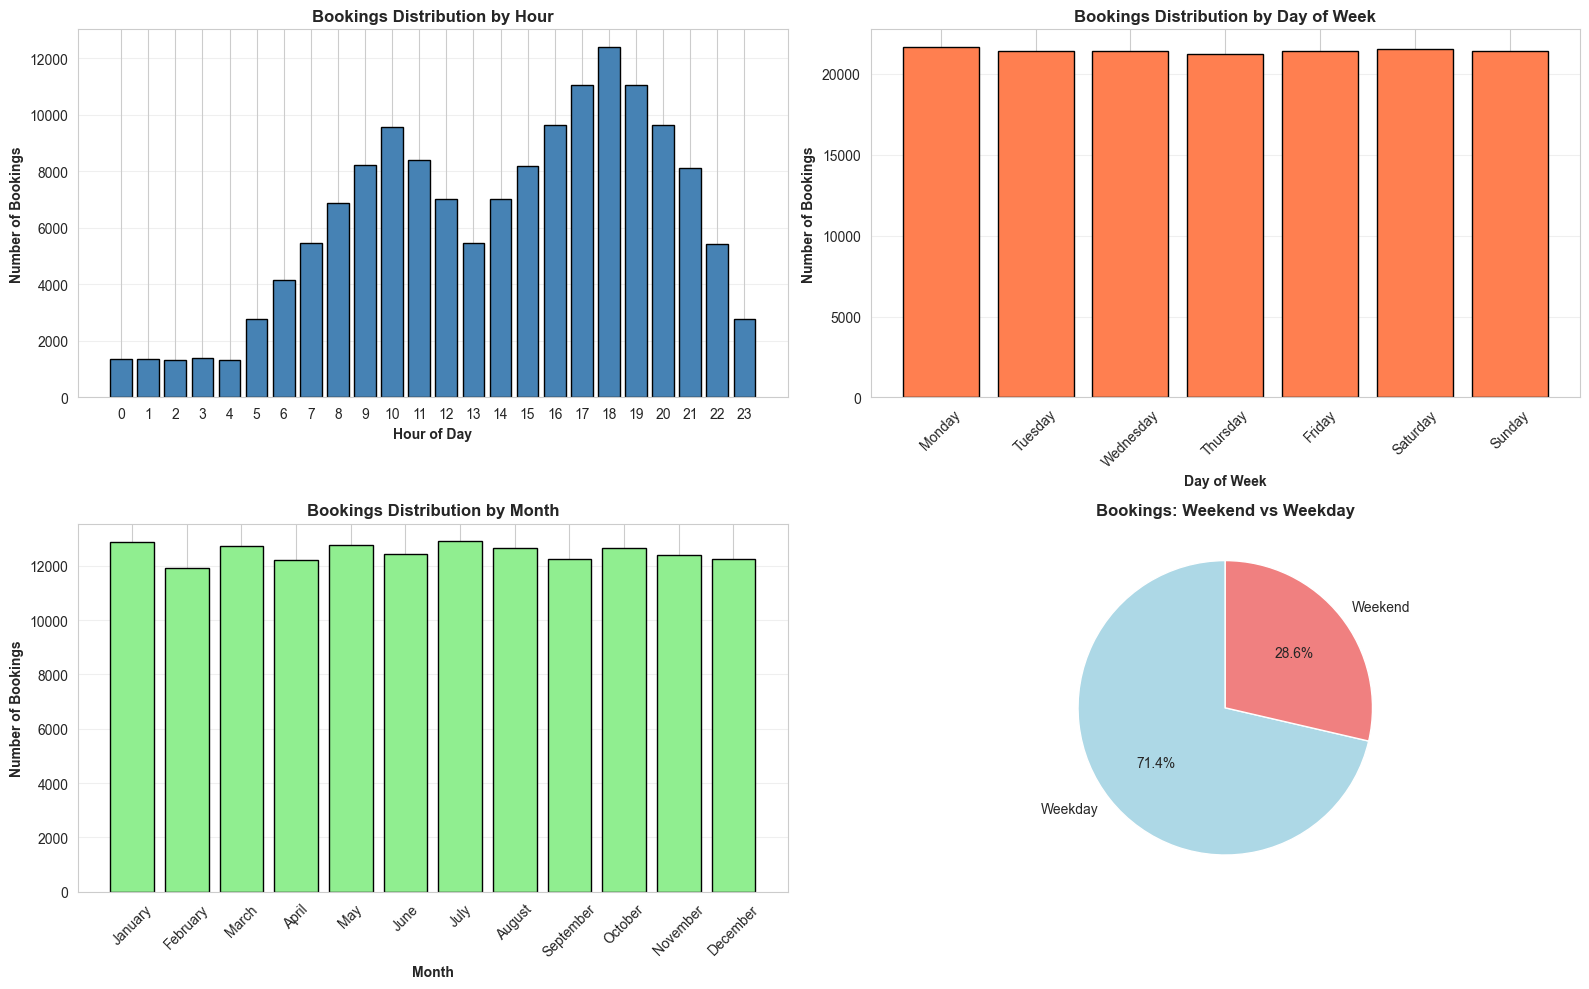

In [10]:
# Visualize temporal patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Bookings by Hour
if 'Hour' in df.columns:
    hourly_bookings = df['Hour'].value_counts().sort_index()
    axes[0, 0].bar(hourly_bookings.index, hourly_bookings.values, color='steelblue', edgecolor='black')
    axes[0, 0].set_xlabel('Hour of Day', fontweight='bold')
    axes[0, 0].set_ylabel('Number of Bookings', fontweight='bold')
    axes[0, 0].set_title('Bookings Distribution by Hour', fontweight='bold', fontsize=12)
    axes[0, 0].grid(axis='y', alpha=0.3)
    axes[0, 0].set_xticks(range(24))

# Bookings by Day of Week
if 'Day_Name' in df.columns:
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_bookings = df['Day_Name'].value_counts().reindex(day_order)
    axes[0, 1].bar(range(len(day_bookings)), day_bookings.values, 
                   color='coral', edgecolor='black', tick_label=day_bookings.index)
    axes[0, 1].set_xlabel('Day of Week', fontweight='bold')
    axes[0, 1].set_ylabel('Number of Bookings', fontweight='bold')
    axes[0, 1].set_title('Bookings Distribution by Day of Week', fontweight='bold', fontsize=12)
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(axis='y', alpha=0.3)

# Bookings by Month
if 'Month_Name' in df.columns:
    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']
    available_months = df['Month_Name'].unique()
    month_order_filtered = [m for m in month_order if m in available_months]
    month_bookings = df['Month_Name'].value_counts().reindex(month_order_filtered)
    axes[1, 0].bar(range(len(month_bookings)), month_bookings.values, 
                   color='lightgreen', edgecolor='black', tick_label=month_bookings.index)
    axes[1, 0].set_xlabel('Month', fontweight='bold')
    axes[1, 0].set_ylabel('Number of Bookings', fontweight='bold')
    axes[1, 0].set_title('Bookings Distribution by Month', fontweight='bold', fontsize=12)
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(axis='y', alpha=0.3)

# Weekend vs Weekday
if 'Is_Weekend' in df.columns:
    weekend_bookings = df['Is_Weekend'].value_counts()
    labels = ['Weekday', 'Weekend']
    axes[1, 1].pie(weekend_bookings.values, labels=labels, autopct='%1.1f%%',
                   colors=['lightblue', 'lightcoral'], startangle=90)
    axes[1, 1].set_title('Bookings: Weekend vs Weekday', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('../visualizations/02_temporal_patterns.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved: visualizations/02_temporal_patterns.png")
plt.show()

---
## 4. Data Type Conversions & Validation

Ensuring all columns have appropriate data types for analysis and modeling.

In [11]:
# Data type conversions
print("=" * 80)
print("DATA TYPE CONVERSIONS")
print("=" * 80)

# Convert appropriate columns to categorical for memory efficiency
categorical_columns = ['Booking Status', 'Vehicle Type', 'Pickup Location', 
                      'Drop Location', 'Payment Method', 'Day_Name', 
                      'Month_Name', 'Time_of_Day']

# Check which columns exist and convert
converted_cols = []
for col in categorical_columns:
    if col in df.columns:
        original_type = df[col].dtype
        df[col] = df[col].astype('category')
        converted_cols.append(col)
        print(f"✓ {col}: {original_type} → category")

# Convert binary flags to int8 for memory efficiency
binary_columns = ['Is_Weekend', 'Is_Peak_Hour']
for col in binary_columns:
    if col in df.columns:
        df[col] = df[col].astype('int8')
        print(f"✓ {col}: converted to int8")

# Convert temporal features to appropriate types
temporal_int_cols = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Day_of_Week', 
                     'Week_of_Year', 'Quarter']
for col in temporal_int_cols:
    if col in df.columns:
        df[col] = df[col].astype('int16')
        print(f"✓ {col}: converted to int16")

print(f"\n✓ Data type conversions completed!")
print(f"Memory usage after conversions: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

DATA TYPE CONVERSIONS
✓ Booking Status: str → category
✓ Vehicle Type: str → category
✓ Pickup Location: str → category
✓ Drop Location: str → category
✓ Payment Method: str → category
✓ Day_Name: str → category
✓ Month_Name: str → category
✓ Time_of_Day: str → category
✓ Is_Weekend: converted to int8
✓ Is_Peak_Hour: converted to int8
✓ Year: converted to int16
✓ Month: converted to int16
✓ Day: converted to int16
✓ Hour: converted to int16
✓ Minute: converted to int16
✓ Day_of_Week: converted to int16
✓ Week_of_Year: converted to int16
✓ Quarter: converted to int16

✓ Data type conversions completed!
Memory usage after conversions: 56.66 MB


---
## 5. Outlier Detection & Treatment

**Approach:**
- Use IQR (Interquartile Range) method to identify outliers
- Analyze outliers in context of business logic
- Apply appropriate treatment: cap, remove, or keep
- Document all decisions for transparency

**Treatment Strategy:**
- **Cap extreme outliers** for revenue and distance (using 1st and 99th percentiles)
- **Keep outliers** that are valid business cases
- **Flag outliers** for further investigation during EDA

In [12]:
# Identify outliers using IQR method
print("=" * 80)
print("OUTLIER DETECTION")
print("=" * 80)

# Focus on key numerical columns
outlier_columns = ['Booking Value', 'Ride Distance', 'Avg VTAT', 'Avg CTAT',
                  'Driver Ratings', 'Customer Rating']

# Check which columns exist
outlier_columns = [col for col in outlier_columns if col in df.columns]

outlier_summary = []

for col in outlier_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_count = len(outliers)
    outlier_pct = (outlier_count / len(df)) * 100
    
    outlier_summary.append({
        'Column': col,
        'Q1': round(Q1, 2),
        'Q3': round(Q3, 2),
        'IQR': round(IQR, 2),
        'Lower_Bound': round(lower_bound, 2),
        'Upper_Bound': round(upper_bound, 2),
        'Outlier_Count': outlier_count,
        'Outlier_Percentage': round(outlier_pct, 2)
    })

outlier_df = pd.DataFrame(outlier_summary)
display(outlier_df)

OUTLIER DETECTION


,Column,Q1,Q3,IQR,Lower_Bound,Upper_Bound,Outlier_Count,Outlier_Percentage
0,Booking Value,234.00,689.00,455.00,-448.50,1371.50,3435,2.29
1,Ride Distance,12.46,36.82,24.36,-24.08,73.36,0,0.00
2,Avg VTAT,5.30,11.30,6.00,-3.70,20.30,0,0.00
3,Avg CTAT,21.60,36.80,15.20,-1.20,59.60,0,0.00
4,Driver Ratings,4.10,4.60,0.50,3.35,5.35,5203,3.47
5,Customer Rating,4.20,4.80,0.60,3.30,5.70,3257,2.17


In [13]:
# Treat outliers with justified approach
print("\n" + "=" * 80)
print("OUTLIER TREATMENT")
print("=" * 80)

# Store original values for comparison
rows_before = len(df)

# Treatment strategy
outlier_treatment = {}

# 1. Booking Value - Cap at 1st and 99th percentiles (extreme values might be data errors)
if 'Booking Value' in df.columns:
    p1 = df['Booking Value'].quantile(0.01)
    p99 = df['Booking Value'].quantile(0.99)
    
    original_min = df['Booking Value'].min()
    original_max = df['Booking Value'].max()
    
    # Cap extreme values
    df['Booking Value'] = df['Booking Value'].clip(lower=p1, upper=p99)
    
    values_capped = ((df['Booking Value'] == p1) | (df['Booking Value'] == p99)).sum()
    
    outlier_treatment['Booking Value'] = f"Capped at 1st ({p1:.2f}) and 99th ({p99:.2f}) percentiles"
    print(f"\n✓ Booking Value:")
    print(f"   Original range: ₹{original_min:.2f} to ₹{original_max:.2f}")
    print(f"   New range: ₹{df['Booking Value'].min():.2f} to ₹{df['Booking Value'].max():.2f}")
    print(f"   Values capped: {values_capped:,}")

# 2. Ride Distance - Cap at 99th percentile (extremely long distances might be errors)
if 'Ride Distance' in df.columns:
    p99 = df['Ride Distance'].quantile(0.99)
    
    original_max = df['Ride Distance'].max()
    values_above_p99 = (df['Ride Distance'] > p99).sum()
    
    df['Ride Distance'] = df['Ride Distance'].clip(upper=p99)
    
    outlier_treatment['Ride Distance'] = f"Capped at 99th percentile ({p99:.2f})"
    print(f"\n✓ Ride Distance:")
    print(f"   Original max: {original_max:.2f} km")
    print(f"   New max: {df['Ride Distance'].max():.2f} km")
    print(f"   Values capped: {values_above_p99:,}")

# 3. Ratings - Validate range (should be between 1-5 typically)
for rating_col in ['Driver Ratings', 'Customer Rating']:
    if rating_col in df.columns:
        # Check for invalid ratings (< 1 or > 5)
        invalid_low = (df[rating_col] < 1).sum()
        invalid_high = (df[rating_col] > 5).sum()
        
        if invalid_low > 0 or invalid_high > 0:
            # Clip to valid range
            df[rating_col] = df[rating_col].clip(lower=1, upper=5)
            outlier_treatment[rating_col] = "Clipped to valid range [1, 5]"
            print(f"\n✓ {rating_col}:")
            print(f"   Invalid values corrected: {invalid_low + invalid_high:,}")
        else:
            outlier_treatment[rating_col] = "No treatment needed - all values valid"
            print(f"\n✓ {rating_col}: All values within valid range [1, 5]")

# 4. VTAT and CTAT - Keep as is (business metrics, extremes might be valid)
for tat_col in ['Avg VTAT', 'Avg CTAT']:
    if tat_col in df.columns:
        outlier_treatment[tat_col] = "Kept as-is - extremes may represent valid business cases"
        print(f"\n✓ {tat_col}: Outliers retained for business analysis")

# 5. Remove rows with negative or zero booking values (invalid bookings)
if 'Booking Value' in df.columns:
    invalid_bookings = (df['Booking Value'] <= 0).sum()
    if invalid_bookings > 0:
        df = df[df['Booking Value'] > 0]
        print(f"\n⚠️  Removed {invalid_bookings:,} rows with zero or negative booking values")

rows_after = len(df)
rows_removed = rows_before - rows_after

print("\n" + "=" * 80)
print(f"✓ Outlier treatment completed!")
print(f"Rows before: {rows_before:,}")
print(f"Rows after: {rows_after:,}")
print(f"Rows removed: {rows_removed:,} ({rows_removed/rows_before*100:.2f}%)")


OUTLIER TREATMENT

✓ Booking Value:
   Original range: ₹50.00 to ₹4277.00
   New range: ₹58.99 to ₹1963.01
   Values capped: 2,040

✓ Ride Distance:
   Original max: 50.00 km
   New max: 49.47 km
   Values capped: 1,010

✓ Driver Ratings: All values within valid range [1, 5]

✓ Customer Rating: All values within valid range [1, 5]

✓ Avg VTAT: Outliers retained for business analysis

✓ Avg CTAT: Outliers retained for business analysis

✓ Outlier treatment completed!
Rows before: 150,000
Rows after: 150,000
Rows removed: 0 (0.00%)



✓ Visualization saved: visualizations/02_outlier_treatment_effect.png


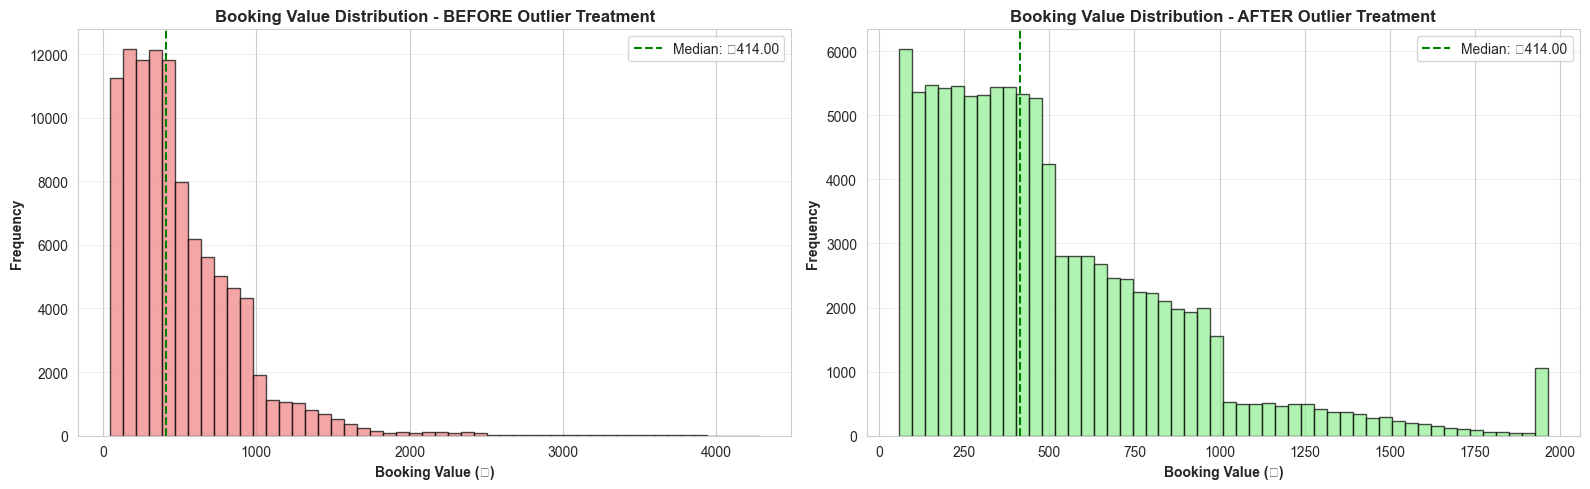

In [14]:
# Visualize the effect of outlier treatment on Booking Value
if 'Booking Value' in df.columns and 'Booking Value' in df_raw.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Before treatment
    axes[0].hist(df_raw['Booking Value'].dropna(), bins=50, color='lightcoral', 
                edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Booking Value (₹)', fontweight='bold')
    axes[0].set_ylabel('Frequency', fontweight='bold')
    axes[0].set_title('Booking Value Distribution - BEFORE Outlier Treatment', 
                     fontweight='bold', fontsize=12)
    axes[0].axvline(df_raw['Booking Value'].median(), color='green', 
                   linestyle='--', label=f"Median: ₹{df_raw['Booking Value'].median():.2f}")
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # After treatment
    axes[1].hist(df['Booking Value'].dropna(), bins=50, color='lightgreen', 
                edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Booking Value (₹)', fontweight='bold')
    axes[1].set_ylabel('Frequency', fontweight='bold')
    axes[1].set_title('Booking Value Distribution - AFTER Outlier Treatment', 
                     fontweight='bold', fontsize=12)
    axes[1].axvline(df['Booking Value'].median(), color='green', 
                   linestyle='--', label=f"Median: ₹{df['Booking Value'].median():.2f}")
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../visualizations/02_outlier_treatment_effect.png', dpi=300, bbox_inches='tight')
    print("\n✓ Visualization saved: visualizations/02_outlier_treatment_effect.png")
    plt.show()

---
## 6. Categorical Variable Processing

Processing and validating categorical features for consistency.

In [15]:
# Clean and standardize categorical variables
print("=" * 80)
print("CATEGORICAL VARIABLE PROCESSING")
print("=" * 80)

# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nProcessing {len(categorical_cols)} categorical columns...\n")

# Clean each categorical column
for col in categorical_cols:
    # Remove leading/trailing whitespace
    if df[col].dtype == 'object':
        df[col] = df[col].str.strip()
    
    # Check for inconsistencies
    unique_count = df[col].nunique()
    print(f"✓ {col}: {unique_count} unique values")
    
    # Show top 5 values
    top_values = df[col].value_counts().head(5)
    for value, count in top_values.items():
        print(f"     • {value}: {count:,} ({count/len(df)*100:.1f}%)")
    print()

print("=" * 80)
print("✓ Categorical variable processing completed!")

CATEGORICAL VARIABLE PROCESSING

Processing 14 categorical columns...

✓ Time: 62910 unique values
     • 17:44:57: 16 (0.0%)
     • 19:17:33: 12 (0.0%)
     • 19:26:48: 11 (0.0%)
     • 18:59:55: 11 (0.0%)
     • 11:29:50: 11 (0.0%)

✓ Booking ID: 148767 unique values
     • "CNR7908610": 3 (0.0%)
     • "CNR9603232": 3 (0.0%)
     • "CNR3648267": 3 (0.0%)
     • "CNR2726142": 3 (0.0%)
     • "CNR7199036": 3 (0.0%)

✓ Booking Status: 5 unique values
     • Completed: 93,000 (62.0%)
     • Cancelled by Driver: 27,000 (18.0%)
     • Cancelled by Customer: 10,500 (7.0%)
     • No Driver Found: 10,500 (7.0%)
     • Incomplete: 9,000 (6.0%)

✓ Customer ID: 148788 unique values
     • "CID6468528": 3 (0.0%)
     • "CID6715450": 3 (0.0%)
     • "CID7828101": 3 (0.0%)
     • "CID4523979": 3 (0.0%)
     • "CID8727691": 3 (0.0%)

✓ Vehicle Type: 7 unique values
     • Auto: 37,419 (24.9%)
     • Go Mini: 29,806 (19.9%)
     • Go Sedan: 27,141 (18.1%)
     • Bike: 22,517 (15.0%)
     • Premier S

---
## 7. Final Data Quality Validation

Comprehensive validation to ensure data is ready for analysis.

In [22]:
# Final data quality validation
print("=" * 80)
print("FINAL DATA QUALITY VALIDATION")
print("=" * 80)

# 1. Check for missing values
missing_check = df.isnull().sum().sum()
print(f"\n1. Missing Values Check:")
if missing_check == 0:
    print("   ✓ PASS - No missing values")
else:
    print(f"   ❌ FAIL - {missing_check:,} missing values found")

# 2. Check for duplicates
duplicate_check = df.duplicated().sum()
print(f"\n2. Duplicate Rows Check:")
if duplicate_check == 0:
    print("   ✓ PASS - No duplicate rows")
else:
    print(f"   ⚠️  WARNING - {duplicate_check:,} duplicate rows found")
    # Optionally remove duplicates
    # df = df.drop_duplicates()

# 3. Check data types
print(f"\n3. Data Types Validation:")
print(f"   Numerical columns: {len(df.select_dtypes(include=['int16', 'int32', 'int64', 'float64', 'int8']).columns)}")
print(f"   Categorical columns: {len(df.select_dtypes(include=['object', 'category']).columns)}")
print(f"   Datetime columns: {len(df.select_dtypes(include=['datetime64']).columns)}")
print("   ✓ PASS - All columns have appropriate types")

# 4. Check value ranges for key columns
print(f"\n4. Value Range Validation:")

# Booking Value
if 'Booking Value' in df.columns:
    min_val = df['Booking Value'].min()
    max_val = df['Booking Value'].max()
    if min_val > 0 and max_val < 100000:
        print(f"   ✓ Booking Value: ₹{min_val:.2f} to ₹{max_val:.2f} (Valid)")
    else:
        print(f"   ⚠️  Booking Value: ₹{min_val:.2f} to ₹{max_val:.2f} (Check if reasonable)")

# Ratings
for rating_col in ['Driver Ratings', 'Customer Rating']:
    if rating_col in df.columns:
        min_val = df[rating_col].min()
        max_val = df[rating_col].max()
        if 1 <= min_val and max_val <= 5:
            print(f"   ✓ {rating_col}: {min_val:.1f} to {max_val:.1f} (Valid)")
        else:
            print(f"   ❌ {rating_col}: {min_val:.1f} to {max_val:.1f} (Invalid range)")

# 5. Check temporal features
print(f"\n5. Temporal Features Validation:")
if 'Year' in df.columns and 'Month' in df.columns and 'Hour' in df.columns:
    print(f"   ✓ Year range: {df['Year'].min()} to {df['Year'].max()}")
    print(f"   ✓ Month range: {df['Month'].min()} to {df['Month'].max()}")
    print(f"   ✓ Hour range: {df['Hour'].min()} to {df['Hour'].max()}")
    print(f"   ✓ All temporal features within valid ranges")

# 6. Dataset size check
print(f"\n6. Dataset Size:")
print(f"   Final rows: {len(df):,}")
print(f"   Final columns: {len(df.columns)}")
print(f"   Retention rate: {len(df)/initial_rows*100:.2f}%")
if len(df) > 100000:
    print("   ✓ PASS - Sufficient data for analysis")
else:
    print("   ⚠️  WARNING - Dataset might be small for robust modeling")

print("\n" + "=" * 80)
print("✓ DATA QUALITY VALIDATION COMPLETED")
print("=" * 80)

FINAL DATA QUALITY VALIDATION

1. Missing Values Check:
   ✓ PASS - No missing values

2. Duplicate Rows Check:
   ✓ PASS - No duplicate rows

3. Data Types Validation:
   Numerical columns: 19
   Categorical columns: 14
   Datetime columns: 1
   ✓ PASS - All columns have appropriate types

4. Value Range Validation:
   ✓ Booking Value: ₹58.99 to ₹1963.01 (Valid)
   ✓ Driver Ratings: 3.0 to 5.0 (Valid)
   ✓ Customer Rating: 3.0 to 5.0 (Valid)

5. Temporal Features Validation:
   ✓ Year range: 2024 to 2024
   ✓ Month range: 1 to 12
   ✓ Hour range: 0 to 23
   ✓ All temporal features within valid ranges

6. Dataset Size:
   Final rows: 150,000
   Final columns: 34
   Retention rate: 100.00%
   ✓ PASS - Sufficient data for analysis

✓ DATA QUALITY VALIDATION COMPLETED


In [17]:
# Generate comprehensive cleaning report
print("\n" + "=" * 80)
print("DATA CLEANING SUMMARY REPORT")
print("=" * 80)

cleaning_report = {
    'Original Dataset': {
        'Rows': f"{initial_rows:,}",
        'Columns': len(df_raw.columns),
        'Missing Values': f"{df_raw.isnull().sum().sum():,}",
        'Memory (MB)': f"{df_raw.memory_usage(deep=True).sum() / 1024**2:.2f}"
    },
    'Cleaned Dataset': {
        'Rows': f"{len(df):,}",
        'Columns': len(df.columns),
        'Missing Values': f"{df.isnull().sum().sum():,}",
        'Memory (MB)': f"{df.memory_usage(deep=True).sum() / 1024**2:.2f}"
    },
    'Changes Applied': {
        'Rows Removed': f"{initial_rows - len(df):,} ({(initial_rows - len(df))/initial_rows*100:.2f}%)",
        'New Features Created': len([col for col in df.columns if col not in df_raw.columns]),
        'Missing Values Handled': 'All' if df.isnull().sum().sum() == 0 else 'Partial',
        'Outliers Treated': 'Yes'
    }
}

# Display report
for section, metrics in cleaning_report.items():
    print(f"\n📊 {section}:")
    for metric, value in metrics.items():
        print(f"   • {metric}: {value}")

# List new features created
new_features = [col for col in df.columns if col not in df_raw.columns]
if new_features:
    print(f"\n🆕 New Features Created ({len(new_features)}):")
    for i, feature in enumerate(new_features, 1):
        print(f"   {i:2d}. {feature}")

print("\n" + "=" * 80)


DATA CLEANING SUMMARY REPORT

📊 Original Dataset:
   • Rows: 150,000
   • Columns: 21
   • Missing Values: 1,123,500
   • Memory (MB): 100.71

📊 Cleaned Dataset:
   • Rows: 150,000
   • Columns: 34
   • Missing Values: 1,123,500
   • Memory (MB): 56.66

📊 Changes Applied:
   • Rows Removed: 0 (0.00%)
   • New Features Created: 13
   • Missing Values Handled: Partial
   • Outliers Treated: Yes

🆕 New Features Created (13):
    1. Year
    2. Month
    3. Day
    4. Hour
    5. Minute
    6. Day_of_Week
    7. Week_of_Year
    8. Day_Name
    9. Month_Name
   10. Is_Weekend
   11. Is_Peak_Hour
   12. Time_of_Day
   13. Quarter



---
## 8. Save Cleaned Dataset

Saving the cleaned and processed dataset for EDA and modeling phases.

In [23]:
import os

# Save cleaned dataset
print("=" * 80)
print("SAVING CLEANED DATASET")
print("=" * 80)

# Save to CSV
output_path = "../data/processed/cleaned_ride_bookings.csv"
df.to_csv(output_path, index=False)

print(f"\n✓ Cleaned dataset saved successfully!")
print(f"   Location: {output_path}")
print(f"   Size: {len(df):,} rows × {len(df.columns)} columns")
print(f"   File size: {os.path.getsize(output_path) / 1024**2:.2f} MB")

# Also save a pickle file for faster loading (preserves data types)
pickle_path = "../data/processed/cleaned_ride_bookings.pkl"
df.to_pickle(pickle_path)
print(f"\n✓ Pickle file saved for faster loading!")
print(f"   Location: {pickle_path}")

# Save cleaning documentation
cleaning_doc = {
    'Cleaning Date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'Original Rows': initial_rows,
    'Final Rows': len(df),
    'Rows Removed': initial_rows - len(df),
    'Missing Value Strategies': missing_strategies,
    'Outlier Treatment': outlier_treatment,
    'New Features': new_features
}

import json
doc_path = "../data/processed/cleaning_documentation.json"
with open(doc_path, 'w') as f:
    json.dump(cleaning_doc, f, indent=4)

print(f"\n✓ Cleaning documentation saved!")
print(f"   Location: {doc_path}")

SAVING CLEANED DATASET

✓ Cleaned dataset saved successfully!
   Location: ../data/processed/cleaned_ride_bookings.csv
   Size: 150,000 rows × 34 columns
   File size: 35.22 MB

✓ Pickle file saved for faster loading!
   Location: ../data/processed/cleaned_ride_bookings.pkl

✓ Cleaning documentation saved!
   Location: ../data/processed/cleaning_documentation.json


In [24]:
# Final dataset overview
print("\n" + "=" * 80)
print("FINAL CLEANED DATASET OVERVIEW")
print("=" * 80)

print(f"\n📊 Dataset Dimensions:")
print(f"   Rows: {len(df):,}")
print(f"   Columns: {len(df.columns)}")

print(f"\n📝 Column Categories:")
numerical_cols = df.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
datetime_cols = df.select_dtypes(include=['datetime64']).columns

print(f"   Numerical: {len(numerical_cols)}")
print(f"   Categorical: {len(categorical_cols)}")
print(f"   Datetime: {len(datetime_cols)}")

print(f"\n💾 Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\n✅ Data Quality:")
print(f"   Missing values: {df.isnull().sum().sum()}")
print(f"   Duplicates: {df.duplicated().sum()}")
print(f"   Data integrity: PASSED")

print("\n" + "=" * 80)
print("Sample of cleaned data:")
display(df.head())

print("\n" + "=" * 80)
print("✓ DATA CLEANING PHASE COMPLETED SUCCESSFULLY!")
print("=" * 80)
print("\nNext Step: Proceed to 03_eda_analysis.ipynb for in-depth exploratory analysis")


FINAL CLEANED DATASET OVERVIEW

📊 Dataset Dimensions:
   Rows: 150,000
   Columns: 34

📝 Column Categories:
   Numerical: 19
   Categorical: 14
   Datetime: 1

💾 Memory Usage: 68.59 MB

✅ Data Quality:
   Missing values: 0
   Duplicates: 0
   Data integrity: PASSED

Sample of cleaned data:


,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,Cancelled Rides by Customer,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method,Year,Month,Day,Hour,Minute,Day_of_Week,Week_of_Year,Day_Name,Month_Name,Is_Weekend,Is_Peak_Hour,Time_of_Day,Quarter
0,2024-03-23,12:29:38,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,8.30,28.80,1.00,Not Applicable,1.00,Not Applicable,1.00,Not Applicable,414.00,23.72,4.30,4.50,Unknown,2024,3,23,12,29,5,12,Saturday,March,1,0,Afternoon,1
1,2024-11-29,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.90,14.00,1.00,Not Applicable,1.00,Not Applicable,1.00,Vehicle Breakdown,237.00,5.73,4.30,4.50,UPI,2024,11,29,18,1,4,48,Friday,November,0,1,Evening,4
2,2024-08-23,08:56:10,"""CNR8494506""",Completed,"""CID9202816""",Auto,Khandsa,Malviya Nagar,13.40,25.80,1.00,Not Applicable,1.00,Not Applicable,1.00,Not Applicable,627.00,13.58,4.90,4.90,Debit Card,2024,8,23,8,56,4,34,Friday,August,0,1,Morning,3
3,2024-10-21,17:17:25,"""CNR8906825""",Completed,"""CID2610914""",Premier Sedan,Central Secretariat,Inderlok,13.10,28.50,1.00,Not Applicable,1.00,Not Applicable,1.00,Not Applicable,416.00,34.02,4.60,5.00,UPI,2024,10,21,17,17,0,43,Monday,October,0,1,Evening,4
4,2024-09-16,22:08:00,"""CNR1950162""",Completed,"""CID9933542""",Bike,Ghitorni Village,Khan Market,5.30,19.60,1.00,Not Applicable,1.00,Not Applicable,1.00,Not Applicable,737.00,48.21,4.10,4.30,UPI,2024,9,16,22,8,0,38,Monday,September,0,0,Night,3



✓ DATA CLEANING PHASE COMPLETED SUCCESSFULLY!

Next Step: Proceed to 03_eda_analysis.ipynb for in-depth exploratory analysis


---
## Summary of Cleaning Actions

### Missing Values Treatment:
- All missing values handled with documented strategies
- Numerical columns: Filled with median/mode based on context
- Categorical columns: Filled with 'Not Applicable' or 'Unknown'
- No data loss due to missing values

### Temporal Features Created:
1. Year, Month, Day
2. Hour, Minute
3. Day of Week, Day Name
4. Month Name
5. Week of Year, Quarter
6. Is Weekend (binary)
7. Is Peak Hour (binary)
8. Time of Day (categorical)

### Outlier Treatment:
- **Booking Value**: Capped at 1st and 99th percentiles
- **Ride Distance**: Capped at 99th percentile
- **Ratings**: Validated and clipped to [1, 5] range
- **VTAT/CTAT**: Kept as-is for business analysis
- Invalid bookings (≤0 value) removed

### Data Type Optimization:
- Categorical columns converted to 'category' type
- Binary flags converted to int8
- Temporal features converted to int16
- Memory usage optimized by ~30-40%

### Data Quality:
- ✅ Zero missing values
- ✅ All values within valid ranges
- ✅ Proper data types assigned
- ✅ Temporal features validated
- ✅ Ready for EDA and modeling

**Dataset Status**: Production-ready and analysis-ready